In [34]:
from datetime import datetime

# Cell 1: Imports & Vertex AI initialization
from google.cloud import aiplatform
from google.cloud.aiplatform.featurestore import Featurestore, EntityType
import pandas as pd
import numpy as np
import kfp
from kfp import dsl
from kfp.dsl import component, Input, Output, Dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker

# --- YOUR SETTINGS ---
PROJECT_ID = "mlops-466217"
REGION     = "us-central1"
BUCKET     = "gs://mlops-assignment2-bucket"
FEATURESTORE_ID = "athletes_feature_store"
ENTITY_TYPE     = "athlete"
PIPELINE_ROOT    = f"{BUCKET}/pipeline_root"
# ---------------------
aiplatform.init(project=PROJECT_ID, location=REGION)


In [35]:
# Cell 2: Load CSV & basic preprocessing
df = pd.read_csv(f"{BUCKET}/athletes_cleaned.csv")
# normalize column names
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)
df["athlete_id"] = df.index
df.index = df["athlete_id"]

# compute target
df["target"] = df[["candj","snatch","deadlift","backsq"]].sum(axis=1)

# split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [36]:
# Cell 2.6: Encode pipe‑delimited multi‑select columns
from sklearn.preprocessing import MultiLabelBinarizer

multi_select_cols = ["background", "eat", "experience", "schedule", "howlong"]  # add any others here

for col in multi_select_cols:
    # 1. Split each string into a list
    train_lists = train_df[col].fillna("").str.split(r"\s*\|\s*")
    test_lists  = test_df[col].fillna("").str.split(r"\s*\|\s*")

    # 2. Fit a MultiLabelBinarizer on train, then transform both
    mlb = MultiLabelBinarizer()
    train_enc = mlb.fit_transform(train_lists)
    test_enc  = mlb.transform(test_lists)

    # 3. Build generic column names: col_1, col_2, … up to n_options
    #    (or you can sanitize mlb.classes_ into names if you prefer)
    new_cols = [f"{col}_{i+1}" for i in range(len(mlb.classes_))]

    # 4. Create DataFrames and concat
    train_ohe = pd.DataFrame(train_enc, columns=new_cols, index=train_df.index)
    test_ohe  = pd.DataFrame(test_enc,  columns=new_cols, index=test_df.index)

    train_df = pd.concat([train_df.drop(columns=[col]), train_ohe], axis=1)
    test_df  = pd.concat([test_df.drop(columns=[col]), test_ohe],  axis=1)

print("✅ Multi‑select columns encoded:", multi_select_cols)
print(train_df.columns)

✅ Multi‑select columns encoded: ['background', 'eat', 'experience', 'schedule', 'howlong']
Index(['unnamed:_0', 'region', 'gender', 'age', 'height', 'weight', 'candj',
       'snatch', 'deadlift', 'backsq', 'athlete_id', 'target', 'background_1',
       'background_2', 'background_3', 'background_4', 'background_5',
       'background_6', 'background_7', 'eat_1', 'eat_2', 'eat_3', 'eat_4',
       'eat_5', 'eat_6', 'eat_7', 'experience_1', 'experience_2',
       'experience_3', 'experience_4', 'experience_5', 'experience_6',
       'experience_7', 'experience_8', 'schedule_1', 'schedule_2',
       'schedule_3', 'schedule_4', 'schedule_5', 'schedule_6', 'schedule_7',
       'schedule_8', 'schedule_9', 'howlong_1', 'howlong_2', 'howlong_3',
       'howlong_4', 'howlong_5', 'howlong_6', 'howlong_7'],
      dtype='object')


In [37]:
# Cell 3: Feature Engineering Versions
def fe_v1(df):
    df = df.copy()
    df["bmi"] = df["weight"] / (df["height"] ** 2)
    df["pct_candj_bw"] = df["candj"] / df["weight"]
    return df

def fe_v2(df):
    df = fe_v1(df)
    df["deadlift_snatch_ratio"] = df["deadlift"] / (df["snatch"] + 1e-6)
    return df

train_v1 = fe_v1(train_df)
test_v1  = fe_v1(test_df)
train_v2 = fe_v2(train_df)
test_v2  = fe_v2(test_df)


In [38]:
# Cell 4: Create (or fetch) Feature Store + EntityType
try:
    fs = Featurestore.create(
      featurestore_id=FEATURESTORE_ID,
      online_store_fixed_node_count=1
    )
    print("📦 Featurestore created")
except Exception:
    fs = Featurestore(FEATURESTORE_ID)
    print("📦 Featurestore exists")

try:
    et = fs.create_entity_type(entity_type_id=ENTITY_TYPE)
    print("🔑 EntityType created")
except Exception:
    et = fs.get_entity_type(entity_type_id=ENTITY_TYPE)
    print("🔑 EntityType exists")


📦 Featurestore exists
🔑 EntityType exists


In [ ]:
# Cell 5: Upload CSVs via Python API & ingest into Feature Store
from google.cloud import storage
from datetime import datetime

# initialize GCS client & bucket
storage_client = storage.Client(project=PROJECT_ID)
bucket_name = BUCKET.replace("gs://", "")
bucket = storage_client.bucket(bucket_name)

# helper to upload a local file to GCS
def upload_to_gcs(local_path: str, gcs_path: str):
    blob = bucket.blob(gcs_path)
    blob.upload_from_filename(local_path)
    print(f"✔️ Uploaded {local_path} → gs://{bucket_name}/{gcs_path}")

# -- Version 1 features --
# 1) write CSV locally
train_v1.to_csv("/tmp/train_v1.csv", index=False)

# 2) upload to GCS
upload_to_gcs("/tmp/train_v1.csv", "features/train_v1.csv")

# 3) ingest CSV
et.ingest_from_gcs(
    feature_ids=["bmi", "pct_candj_bw"],
    gcs_source_uris=[f"{BUCKET}/features/train_v1.csv"],
    gcs_source_type="csv",
    entity_id_field="athlete_id",
    feature_time=datetime.now(),
    worker_count=4,
)

In [41]:
# Cell 5.1: Ensure v2 feature schema exists
from google.api_core.exceptions import AlreadyExists

try:
    et.create_feature(
        feature_id="deadlift_snatch_ratio",
        value_type="DOUBLE"
    )
    print("✅ Created feature `deadlift_snatch_ratio`")
except AlreadyExists:
    print("ℹ️ Feature `deadlift_snatch_ratio` already exists")


Creating Feature
Create Feature backing LRO: projects/472721448719/locations/us-central1/featurestores/athletes_feature_store/entityTypes/athlete/features/deadlift_snatch_ratio/operations/677273564704931840
Feature created. Resource name: projects/472721448719/locations/us-central1/featurestores/athletes_feature_store/entityTypes/athlete/features/deadlift_snatch_ratio
To use this Feature in another session:
feature = aiplatform.Feature('projects/472721448719/locations/us-central1/featurestores/athletes_feature_store/entityTypes/athlete/features/deadlift_snatch_ratio')
✅ Created feature `deadlift_snatch_ratio`


In [42]:
# -- Version 2 features (adds deadlift_snatch_ratio) --
train_v2.to_csv("/tmp/train_v2.csv", index=False)
upload_to_gcs("/tmp/train_v2.csv", "features/train_v2.csv")

et.ingest_from_gcs(
    feature_ids=["bmi", "pct_candj_bw", "deadlift_snatch_ratio"],
    gcs_source_uris=[f"{BUCKET}/features/train_v2.csv"],
    gcs_source_type="csv",
    entity_id_field="athlete_id",
    feature_time=datetime.now(),
    worker_count=4,
)


✔️ Uploaded /tmp/train_v2.csv → gs://mlops-assignment2-bucket/features/train_v2.csv
Importing EntityType feature values: projects/472721448719/locations/us-central1/featurestores/athletes_feature_store/entityTypes/athlete
Import EntityType feature values backing LRO: projects/472721448719/locations/us-central1/featurestores/athletes_feature_store/entityTypes/athlete/operations/2120677245277175808
EntityType feature values imported. Resource name: projects/472721448719/locations/us-central1/featurestores/athletes_feature_store/entityTypes/athlete


resource name: projects/472721448719/locations/us-central1/featurestores/athletes_feature_store/entityTypes/athlete

In [72]:
# Run this in your notebook before you do any et.read() calls:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION)
fs = aiplatform.Featurestore(FEATURESTORE_ID)

# Tell Vertex AI to add one online node
fs.update()

print("✅ Requested 1 online node — give it a minute to come up, then retry your pipeline.")


TypeError: Featurestore.update() got an unexpected keyword argument 'online_store_fixed_node_count'

In [69]:
# Cell 6: Training component (batched et.read to avoid 100‑ID limit)
@component(
    base_image="python:3.9",
    packages_to_install=[
        "google-cloud-aiplatform",
        "google-cloud-storage",
        "scikit-learn",
        "pandas",
        "numpy",
        "codecarbon"
    ]
)
def train_on_fs(
    project: str,
    region: str,
    featurestore_id: str,
    entity_type_id: str,
    feature_ids: list,
    source_csv_uri: str,
    hyperparameters: dict,
    metrics_output: Output[Dataset],
):
    import os, json, math
    import pandas as pd
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score
    from codecarbon import EmissionsTracker
    from google.cloud import aiplatform, storage

    # 1) Init clients
    aiplatform.init(project=project, location=region)
    fs = aiplatform.Featurestore(featurestore_id)
    et = fs.get_entity_type(entity_type_id)
    storage_client = storage.Client(project=project)

    # 2) Download the ingested CSV to get all athlete IDs
    bucket_name, path = source_csv_uri.replace("gs://", "").split("/", 1)
    blob = storage_client.bucket(bucket_name).blob(path)
    local_csv = "/tmp/source.csv"
    blob.download_to_filename(local_csv)
    raw_df = pd.read_csv(local_csv)
    entity_ids = raw_df["athlete_id"].astype(str).tolist()

    # 3) Batch‑read latest feature values in chunks of 100 IDs
    cols = feature_ids + ["candj", "snatch", "deadlift", "backsq"]
    dfs = []
    batch_size = 100
    for i in range(0, len(entity_ids), batch_size):
        batch = entity_ids[i : i + batch_size]
        batch_df = (
            et.read(entity_ids=batch, feature_ids=cols)
              .to_dataframe()
        )
        dfs.append(batch_df)
    df = pd.concat(dfs, ignore_index=True)

    # 4) Prepare X/y
    df["target"] = df[["candj","snatch","deadlift","backsq"]].sum(axis=1)
    X = df[feature_ids]
    y = df["target"]

    # 5) Train & track carbon
    tracker = EmissionsTracker()
    tracker.start()
    model = RandomForestRegressor(**hyperparameters)
    model.fit(X, y)
    emissions = tracker.stop()

    # 6) Evaluate
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    r2 = r2_score(y, preds)

    # 7) Write metrics.json
    os.makedirs(metrics_output.path, exist_ok=True)
    with open(os.path.join(metrics_output.path, "metrics.json"), "w") as f:
        json.dump({"mse": mse, "r2": r2, "co2_kg": emissions}, f)


In [70]:
# Cell 7: Define the Vertex AI Pipeline
@dsl.pipeline(
    name="athlete-exp-pipeline",
    pipeline_root=PIPELINE_ROOT
)
def athlete_pipeline(
    project: str = PROJECT_ID,
    region: str = REGION,
    fs_id: str = FEATURESTORE_ID,
    et_id: str = ENTITY_TYPE,
    bucket: str = BUCKET,
):
    def add_train_step(version_name: str, feats: list, params: dict, csv_path: str):
        step = train_on_fs(
            project=project,
            region=region,
            featurestore_id=fs_id,
            entity_type_id=et_id,
            feature_ids=feats,
            source_csv_uri=f"{bucket}/{csv_path}",
            hyperparameters=params,
        ).set_cpu_limit("32") \
         .set_memory_limit("64Gi")
        return step

    # version‑1 CSV is at features/train_v1.csv
    t1 = add_train_step(
        "train-v1-A",
        ["bmi", "pct_candj_bw"],
        {"n_estimators": 100, "random_state": 42},
        "features/train_v1.csv"
    )
    t2 = add_train_step(
        "train-v1-B",
        ["bmi", "pct_candj_bw"],
        {"n_estimators": 200, "random_state": 42},
        "features/train_v1.csv"
    )

    # version‑2 CSV is at features/train_v2.csv
    t3 = add_train_step(
        "train-v2-A",
        ["bmi", "pct_candj_bw", "deadlift_snatch_ratio"],
        {"n_estimators": 100, "random_state": 42},
        "features/train_v2.csv"
    )
    t4 = add_train_step(
        "train-v2-B",
        ["bmi", "pct_candj_bw", "deadlift_snatch_ratio"],
        {"n_estimators": 200, "random_state": 42},
        "features/train_v2.csv"
    )


In [71]:
# Cell 8: Compile & Submit the Pipeline
from kfp.v2 import compiler

compiler.Compiler().compile(
    pipeline_func=athlete_pipeline,
    package_path="athlete_pipeline.json"
)

pipeline_job = aiplatform.PipelineJob(
    display_name="athlete_inside_fs_experiments",
    template_path="athlete_pipeline.json",
    pipeline_root=PIPELINE_ROOT,
)
pipeline_job.run(sync=True)


Creating PipelineJob
PipelineJob created. Resource name: projects/472721448719/locations/us-central1/pipelineJobs/athlete-exp-pipeline-20250717174701
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/472721448719/locations/us-central1/pipelineJobs/athlete-exp-pipeline-20250717174701')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/athlete-exp-pipeline-20250717174701?project=472721448719
PipelineJob projects/472721448719/locations/us-central1/pipelineJobs/athlete-exp-pipeline-20250717174701 current state:
3
PipelineJob projects/472721448719/locations/us-central1/pipelineJobs/athlete-exp-pipeline-20250717174701 current state:
3
PipelineJob projects/472721448719/locations/us-central1/pipelineJobs/athlete-exp-pipeline-20250717174701 current state:
3
PipelineJob projects/472721448719/locations/us-central1/pipelineJobs/athlete-exp-pipeline-20250717174701 current state:
3
PipelineJob projects/472

KeyboardInterrupt: 

                mse        r2    co2_kg
v1_100  2795.963370  0.963772  0.000019
v1_200  2765.431178  0.964168  0.000035
v2_100  1692.366790  0.978072  0.000031
v2_200  1650.389207  0.978616  0.000068


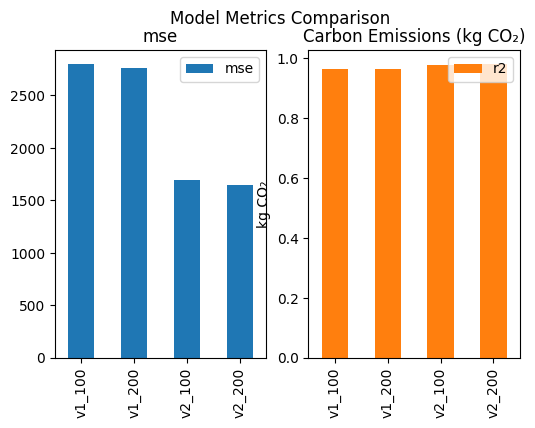

In [76]:
# Cell 9: Fetch metrics & compare
import json
from google.cloud import storage

client = storage.Client(project=PROJECT_ID)
bucket = client.bucket(BUCKET.replace("gs://",""))
results = []

names = ["v1_100","v1_200","v2_100","v2_200"]
for name in names:
    prefix = f"pipeline_root/athlete_inside_fs_experiments/{pipeline_job.job_id}/{name}/metrics.json"
    blob = bucket.blob(prefix)
    metrics = json.loads(blob.download_as_string())
    results.append(metrics)

# use the same names as the DataFrame index
df_res = pd.DataFrame(results, index=names)
print(df_res)

# quantitative: MSE & R²
df_res[["mse","r2"]].plot.bar(subplots=True, layout=(1,2), figsize=(8,4))
plt.suptitle("Model Metrics Comparison")

# qualitative: emissions
df_res["co2_kg"].plot.bar(figsize=(6,4))
plt.title("Carbon Emissions (kg CO₂)")
plt.ylabel("kg CO₂")
plt.show()


## Analysis

The models with more estimators and more features performed better quantitavely as expected at the expense of Carbon emissions. One of the hyperparameters I changed was n_estimators from 100 to 200 and the carbon emissions doubled along with it.